# Special case: evaporation of water
**TL;DR:** Estimation of rates and yields is an important step in characterization and selection of cell factories and bioprocess. Evaporation of water from the bioreactor will bias the estimated yields and rates. Using the Pseudo batch transformation one can estimate the correct values when evaporation is significant.

## Why care about evaporation?
Evaporation of water from a bioreactor will bias the estimated titer, rates and yields if it is not properly accounted for. As a motivating example, imagine a batch bioreactor with an initial volume of 100 ml. When analysing batch processes it is common to assume that any change in concentration is caused by the metabolic activity of the organism in the reactor. However, if 10 ml water evaporated during the process this would cause a significant increase in concentration which is unrelated to the metabolic activity. As result the production rates will appear larger causing the strains to look more attractive, than reality.

Evaporation can vary a lot between different bioreactor equipment and scales, thus evaporation could very well take a part of the blame for the performance variation of cell factories at different scales. The cause of the varying evaporation is multifaceted and can originate from dryness of process air, presence of condensers, differences in agitation method, etc [1]. Thus, the same strain can appear to perform differently in between cultivation setups if evaporation is not accounted for in the bioreactor volume.

For fed-batch fermentations, evaporation adds an additional source of volume change. The Pseudo batch transformation can handle scenarios where evaporation is significant, however to get accurate estimates of rates and yields the transformation method needs the true volume of the bioreactor. The true volume data may not always be accessible. This tutorial have two objectives
1. Show that the Pseudo batch transformation method works when water evaporation is significant 
2. Illustrate a common scenario where the evaporation is not accounted for in the volume data.

Before we start we will first load the necessary Python packages and functions.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pseudobatch import pseudobatch_transform_pandas
from pseudobatch.datasets import load_evaporation_fedbatch

## Pseudo batch transformation works when evaporation is significant
The `pseudobatch` package holds an example dataset which is produced to mimic a fed-batch process with an exponential feeding profile where water evaporates from the bioreactor at a constant rate (The simulation script are found in https://github.com/biosustain/pseudobatch/article/simulation_scripts/fed-batch_evaporation.jl). This data is loaded in the code block below. We also show some of the data columns to give an overview of the structure of this data frame.

In [2]:
fedbatch_df = load_evaporation_fedbatch()
fedbatch_df[['timestamp','sample_volume', 'c_Glucose', 'c_Biomass','c_Product', 'c_CO2', 'v_Volume', 'v_Feed_accum']].head()

,timestamp,sample_volume,c_Glucose,c_Biomass,c_Product,c_CO2,v_Volume,v_Feed_accum
0,0.00000,0.0,0.075000,0.500000,0.000000,0.0,1000.000000,0.000000
1,0.06006,0.0,0.075004,0.503014,0.002474,0.0,999.995704,0.055765
2,0.12012,0.0,0.075009,0.506047,0.004964,0.0,999.991745,0.111865
3,0.18018,0.0,0.075013,0.509097,0.007469,0.0,999.988123,0.168303
4,0.24024,0.0,0.075016,0.512166,0.009988,0.0,999.984842,0.225082


To show the effect of the evaporation, we will calculate the expected volume if no volume evaporated. This is simply done by starting with the initial reactor volume, then adding the volume of feed and subtracting the sample volume. Below we calculate the expected volume and store it in a column of the dataframe.

<Axes: xlabel='timestamp'>

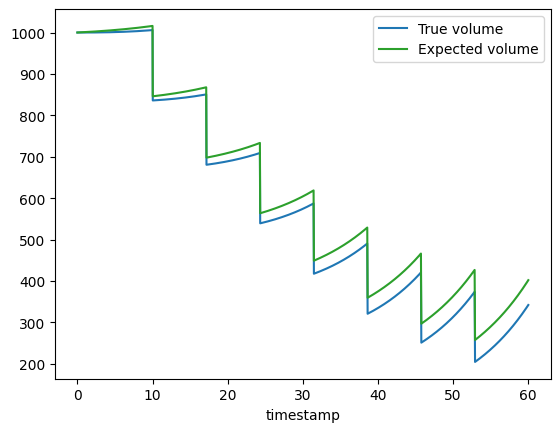

In [19]:
initial_volume = fedbatch_df['v_Volume'].iloc[0]

# Calculated the expected volume by tracking known volume changing 
# events. For the Pseudo batch transform the volume has to be the 
# volume BEFORE sampling. Therefore the sampling volume data is 
# shifted one position before the cumsum.
fedbatch_df['expected_volume'] = (
    initial_volume 
    + fedbatch_df['v_Feed_accum']
    - fedbatch_df['sample_volume'].shift(1, fill_value=0).cumsum()
)

fedbatch_df.plot(
    x='timestamp',
    y=['v_Volume', 'expected_volume'],
    label=['True volume', "Expected volume"],
    color=['C0', 'C2']
)

This plot clearly shows that the expected volume (orange line) diverges from the true volume (blue line) of the bioreactor. This divergence is caused by volume evaporation. To estimate the correct rates and yields using the Pseudo batch transformation the true bioreactor volume is required. In real world scenarios the true volume may not be known, this is discussed further in the next section. For now we will use the simulated true volume to validate the Pseudo batch transformation method.

In the following code block the Pseudo batch transformed biomass and glucose concentrations are calculated.


In [4]:
substrate_in_feed = fedbatch_df['s_f'].iloc[0]
fedbatch_df[['pseudo_Biomass', 'pseudo_Glucose']] = pseudobatch_transform_pandas(
    df=fedbatch_df,
    measured_concentration_colnames=["c_Biomass", "c_Glucose"],
    reactor_volume_colname='v_Volume',
    accumulated_feed_colname='v_Feed_accum',
    concentration_in_feed=[0,substrate_in_feed],
    sample_volume_colname='sample_volume'
)

We will use the standard linear modelling procedures to estimate the specific growth rate and the substrate yield coefficient from the Pseudo batch transformed data.

In [5]:
mu0_hat, intercept = np.polyfit(fedbatch_df['timestamp'], fedbatch_df['pseudo_Biomass'].transform(np.log), 1)
print(f"mu0_hat = {round(mu0_hat, 5)}")
print(f"true mu0 = {fedbatch_df['mu0'].iloc[-1]}")

mu0_hat = 0.1
true mu0 = 0.1


In [6]:
Yxs_hat, intercept = np.polyfit(fedbatch_df['pseudo_Biomass'], fedbatch_df['pseudo_Glucose'], 1)
print(f"Yxs_hat = {abs(Yxs_hat)}")
print(f"true Yxs = {fedbatch_df['Yxs'].iloc[-1]}")

Yxs_hat = 1.8500000000000008
true Yxs = 1.85


We see that both of the estimated parameters match the true simulated parameters, thus showing that the Pseudo batch transformation can be used in situations where the evaporation is present.

## What happens when volume data does not account for evaporation
In some cultivation systems the volume is not actually measured. This is the case for the M2labs Biolector and Robolector cultivation systems and the Sartorius Ambr® 15 and Ambr® 250 systems. Instead the reactor volume is inferred by keeping track of the liquid going in and out of the reactor. This method does not account for the evaporation of water from the system and will overestimate the actual volume of the reactor. In the simulated example used above, this would mean that the volume time series data outputted from the instrument would be the "Expected volume" and NOT the "True volume" (See plot above).

Let's investigate what happens if we estimate the specific growth rate and substrate yield using the biassed volume data.


In [7]:
fedbatch_df[['pseudo_Biomass_wrong_volume', 'pseudo_Glucose_wrong_volume']] = pseudobatch_transform_pandas(
    df=fedbatch_df,
    measured_concentration_colnames=["c_Biomass", "c_Glucose"],
    reactor_volume_colname='expected_volume',
    accumulated_feed_colname='v_Feed_accum',
    concentration_in_feed=[0,substrate_in_feed],
    sample_volume_colname='sample_volume'
)

Using the regular linear model, we can estimate the rate and yield from the Pseudo batch concentration based on the wrong volume.

In [8]:
mu0_hat, intercept = np.polyfit(fedbatch_df['timestamp'], fedbatch_df['pseudo_Biomass_wrong_volume'].transform(np.log), 1)
print(f"mu0_hat = {round(mu0_hat, 5)}")
print(f"true mu0 = {fedbatch_df['mu0'].iloc[-1]}")

mu0_hat = 0.09959
true mu0 = 0.1


In [9]:
Yxs_hat, intercept = np.polyfit(fedbatch_df['pseudo_Biomass_wrong_volume'], fedbatch_df['pseudo_Glucose_wrong_volume'], 1)
print(f"Yxs_hat = {abs(Yxs_hat)}")
print(f"true Yxs = {fedbatch_df['Yxs'].iloc[-1]}")

Yxs_hat = 1.6852002355943905
true Yxs = 1.85


Here we see that both the specific growth rate and the substrate yield estimates are biased. However, the bias of the growth rate is very small. It is important to note that the size of these biases are dependent on the specific evaporation rate, bioprocess, strain, etc. but the bottom line is that there will be a bias.

To improve the estimated rates and yields, we need to estimate the true bioreactor volume. To estimate the true bioreactor volume we need a function which can calculate/estimate how much water has evaporated from the bioreactor at each time point. Below we will implement a Python function to calculate the amount of volume evaporated. For this illustration case, we will assume that the water evaporates at a constant rate. Therefore the accumulated evaporation over a given time period is calculated as

$$
V_{evaporated} = (t_1 - t_0) * evaporation\_rate
$$


Here the evaporated volume of water ($V_{evaporated}$) is a function of three parameters: the initial timepoint ($t_0$), the final time point ($t_1$) and the evaporation rate ($evaporation\_rate$). One could easily imagine modelling the evaporation rate as a function of other factors such as temperature, stirring speed, etc. We leave it up to the user to decide how they will model evaporation in their setup.

**IMPORTANT NOTE:** I, the authors of this tutorial, am not an expert in evaporation, and thus this evaporation function is purely for the sake of the example. We do not recommend using this function for volume correction, instead please refer to the literature on this topic.

Now we implement the evaporation function described above.


In [10]:
def evaporated_volume(t1, t0, evaporation_rate):
    """Calculates the liquid phase volume of evaporated water during a 
    timespan t0 to t1, assuming that the water evaporates at a known 
    fixed rate."""
    return (t1 - t0) * evaporation_rate 

As this is a simulated data set we know the true evaporation rate, which is stored in the `evap_rate` column of the data frame.

In [11]:
simulated_evaporation_rate = fedbatch_df.evap_rate.iloc[0]
print(f"Simulated evaporation rate {simulated_evaporation_rate} µL/h")

Simulated evaporation rate 1.0 µL/h


Now we will estimate the volume of evaporated water for each time step using the function we defined above.

In [12]:
fedbatch_df['estimated_evaporated_volume'] = fedbatch_df['timestamp'].apply(evaporated_volume, t0=0, evaporation_rate=simulated_evaporation_rate)

Then we can estimate the true volume of the bioreactor by subtracting the evaporated volume from the "measured" volume.

In [13]:
fedbatch_df['estimated_true_volume'] = fedbatch_df['expected_volume'] - fedbatch_df['estimated_evaporated_volume']

Finally, we can visualize the "measured", estimated and the true volume to see that the estimated true volume is similar to the true volume.

<Axes: xlabel='timestamp'>

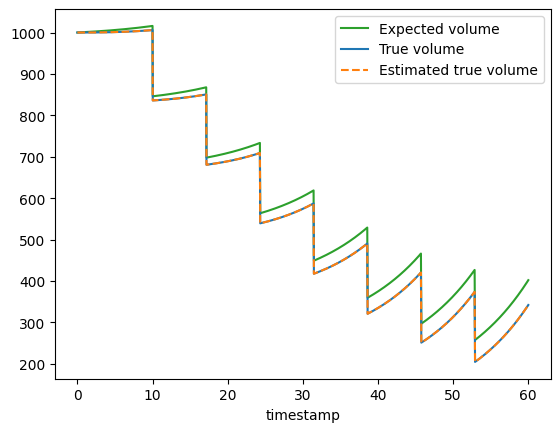

In [18]:
fedbatch_df.plot(
    x='timestamp',
    y=['expected_volume','v_Volume', 'estimated_true_volume'],
    label=["Expected volume", 'True volume', "Estimated true volume"],
    style=['-', '-', '--'],
    color=['C2', 'C0', 'C1']
)

We see that the estimated true volume (green dashed line) follows the true volume (blue solid line) showing that we successfully estimated the true volume. In a real world scenario the true volume will rarely be known and one will have to live with the uncertainty that this introduces into the rate and yield estimates.

To make the example complete we will estimate the specific growth rate and substrate yield using the estimated true volume for the Pseudo batch transformation.

In [15]:
fedbatch_df[['pseudo_Biomass_estimated_volume', 'pseudo_Glucose_estimated_volume']] = pseudobatch_transform_pandas(
    df=fedbatch_df,
    measured_concentration_colnames=["c_Biomass", "c_Glucose"],
    reactor_volume_colname='estimated_true_volume',
    accumulated_feed_colname='v_Feed_accum',
    concentration_in_feed=[0,substrate_in_feed],
    sample_volume_colname='sample_volume'
)

In [16]:
mu0_hat, intercept = np.polyfit(fedbatch_df['timestamp'], fedbatch_df['pseudo_Biomass_estimated_volume'].transform(np.log), 1)
print(f"mu0_hat = {round(mu0_hat, 5)}")
print(f"true mu0 = {fedbatch_df['mu0'].iloc[-1]}")

mu0_hat = 0.1
true mu0 = 0.1


In [17]:
Yxs_hat, intercept = np.polyfit(fedbatch_df['pseudo_Biomass_estimated_volume'], fedbatch_df['pseudo_Glucose_estimated_volume'], 1)
print(f"Yxs_hat = {abs(Yxs_hat)}")
print(f"true Yxs = {fedbatch_df['Yxs'].iloc[-1]}")

Yxs_hat = 1.850000000000001
true Yxs = 1.85


As expected the calculated rate and yield match the simulated parameters. This high accuracy is of course only possible because we here work with simulated data and know the true evaporation rate.

## Conclusion
During this tutorial, we have shown that the Pseudo batch transformation is applicable, when significant amounts of water evaporate from the bioreactor. Furthermore, the tutorial highlighted some of the considerations concerning evaporation from bioreactors and illustrated an overall approach to account for water evaporation when applying the Pseudo batch transformation.

## References
[1] M. Ask and S. M. Stocks, “Aerobic bioreactors: condensers, evaporation rates, scale-up and scale-down,” Biotechnol Lett, vol. 44, no. 7, pp. 813–822, Jul. 2022, doi: 10.1007/s10529-022-03258-7.